# Expected goals - Using the XG model to analyse a match

Date : 21/03/2021

Author : Chloe GOBÉ

This code is presented with two JupyterNotebooks (Step 1 et Step 2)

Functions that I have not written myself are in FriendOfTracking.py and have been written by Laurie Shaw. 
The functions written for this challenge can be found in Functions_Step2.py


Data can be found at: https://github.com/metrica-sports/sample-data (Game 2)

## Set up & Data wrangling

In [8]:
# Import
import FriendsOfTracking as fot
import Functions_Step_2 as func

# Data Visualisation
import seaborn as sns
from matplotlib.patches import Circle, Polygon
import matplotlib.pyplot as plt
from IPython import display

# Other
import pickle

# Data wrangling
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
# Events data
df_events = pd.read_csv("Sample_Game_2_RawEventsData.csv")

# Tracking data
tracking_home = fot.tracking_data("Home")
tracking_away = fot.tracking_data("Away")

Reading team: home
Reading team: away


In [3]:
# Metrica define the origin at the top-left of the field, needs to change the origin
df_events = fot.to_metric_coordinates(df_events)
tracking_away = fot.to_metric_coordinates(tracking_away)
tracking_home = fot.to_metric_coordinates(tracking_home)

In [4]:
# Flip the direction of the attacking teams for the 2nd half
tracking_home,tracking_away,df_events = fot.to_single_playing_direction(tracking_home,tracking_away,df_events)

In [5]:
# Shots
shots = df_events[df_events['Type']=='SHOT']

# Get events by team
home_shots = shots[shots['Team']=='Home']
away_shots = shots[shots['Team']=='Away']

# Get the shots that led to a goal
home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

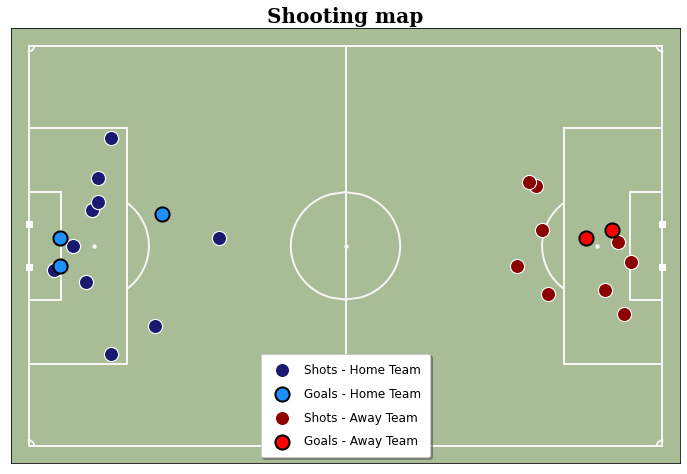

In [7]:
# Visualizing the shots and goals of the game
fig, ax = fot.plot_pitch()

# Home
sns.scatterplot(x=home_shots["Start X"], y=home_shots["Start Y"], 
                s=200,color="MidnightBlue",marker="o", label="Shots - Home Team",ax=ax, zorder=10)
sns.scatterplot(x=home_goals["Start X"], y=home_goals["Start Y"], 
                s=200,color="dodgerblue",marker="o", label="Goals - Home Team",
                ax=ax, edgecolor="black", linewidth=2, zorder=10)

# Away
sns.scatterplot(x=away_shots["Start X"], y=away_shots["Start Y"], 
                s=200,color="darkred",marker="o", label="Shots - Away Team",ax=ax, zorder=10)
sns.scatterplot(x=away_goals["Start X"], y=away_goals["Start Y"], 
                s=200,color="red",marker="o", label="Goals - Away Team",
                ax=ax, edgecolor="black", linewidth=2, zorder=10)


plt.title("Shooting map", fontsize=20, fontfamily="serif", color="black", weight="black")
plt.legend(loc='lower center',fontsize=12, markerscale=1,borderpad=0.8, labelspacing=0.9,shadow=True)
plt.show()


We can easily see that the final score is 3 - 2

## Creating the features

In order to be able to use the model developped in Step1, I am going to transform the data

### Shot angle and Distance to goal


In [10]:
# Apply the functions 
shots["ShotAngle"] = shots.apply(lambda row: func.shot_angle_2(row["Start X"], row["Start Y"]), axis=1)
shots["DistanceToGoal"] = shots.apply(lambda row: func.distance_goal_2(row["Start X"], row["Start Y"]), axis=1)
shots.head(5)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,ShotAngle,DistanceToGoal
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,-39.22,18.36,-55.12,2.72,0.193935,22.956001
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04,0.975859,6.296825
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,-41.34,11.56,-48.76,0.68,0.321587,16.419172
297,Away,SHOT,BLOCKED,1,18515,740.60,18520,740.80,Player22,NaN,31.80,10.20,38.16,11.56,0.279795,23.526156
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,-43.46,-6.12,-54.06,-6.12,0.545456,11.334284


### Play Type

In [11]:
# In order to know what kind in shot this is, I look at the previous event
# Returns a list of (id, play_type) for the shots that are not taken in the open play
shots_different_playtypes = func.which_play_type(df_events)
shots_different_playtypes

[(1671, 'Penalty'), (1843, 'Free Kick'), (1927, 'Free Kick')]

In [12]:
# Add the information of play_type, by default Open Play
shots["play_type"] = "Open Play"

for index, play_type in shots_different_playtypes:
    shots.loc[index, "play_type"] = play_type

shots["play_type"].value_counts()

### BodyPart

In [16]:
# Take the body part info in the subtype column
shots["BodyPart"] = shots["Subtype"].apply(lambda x: "Head" if ("HEAD" in x) else "Feet")
shots["BodyPart"].value_counts()

Feet    17
Head     7
Name: BodyPart, dtype: int64

### Goal


In [17]:
shots["Goal"] = shots['Subtype'].apply(lambda x: 1 if "GOAL" in str(x) else 0)
shots["Goal"].value_counts()

0    19
1     5
Name: Goal, dtype: int64

### Intervening Opponents

I am going to count the number of opponents players in the yellow area : they are on the trajectory of the shot.

The player (x,y) is in the area if he/she is between the 3 straight-lines

For a better understanding, the functions are written within the notebook

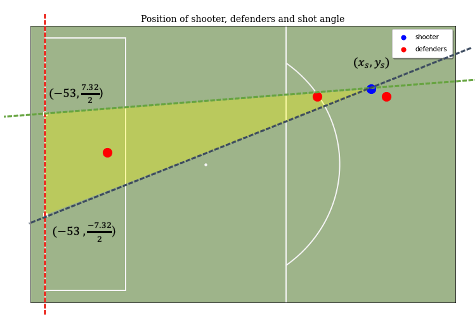

In [9]:
display.Image("img-notebook/intervening.png")

In [18]:
def is_oscuring_goal(coord_shooter, coord_opponents):
    """
    Determine if an opponent is in the trajectory of a potential goal

    Args:
        coord_shooter (tuple of floats): x, y of the shot-taker
        coord_opponents (tuple of floats): x, y of the opponent

    Returns:
        binary : yes or no 
    """
    x_s, y_s = coord_shooter[0], coord_shooter[1] # shot-taker
    x, y = coord_opponents[0], coord_opponents[1] # Opponent
    signe = np.sign(x_s)
    condition1 = 53 >= abs(x) >= abs(x_s) # Red Line
    condition2 =  ((y_s + 7.32/2) / (x_s - signe * 53)) * (x - x_s) + y_s  <= y  # Green Line
    condition3 = y <= ((y_s - 7.32/2) / (x_s - signe * 53)) * (x - x_s) + y_s   # Grey Line
    if condition1 & condition2 & condition3:
        return 1
    return 0


def calculate_number_blocking_opponents(row):
    """
    Determine how many opponents are blocking the view of the shot-taker
    Inspiration : Friends of Tracking - Laurie Shaw

    Args:
        row (row of a pandas DataFrame): positions of the opponents

    Returns:
        int : number of opponents in the area
    """
    goal_frame = row["Start Frame"]
    teamname = row["Team"]
    if teamname == "Home" : 
        team = tracking_away.loc[goal_frame]
    if teamname == "Away":
        team = tracking_home.loc[goal_frame]
    x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
    y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions

    coordinates = list(zip(team[x_columns], team[y_columns]))
    shooter_coord = row["Start X"], row["Start Y"]

    return sum([is_oscuring_goal(shooter_coord, coor) for coor in coordinates])


In [19]:
shots["Number_Intervening_Opponents"] = shots.apply(calculate_number_blocking_opponents, axis=1)

### Interference

Interference_on_shot-taker: The degree of direct interference exerted on the shot-taker from defenders 
- Low - no or minimal interference
-  Medium - a single defender was in close proximity to the shot-taker
- High - multiple defenders in close proximity and interfering with the shot

I am going to define an area in which I am counting the number of opponents

The player (x,y) is in the area if he/she is in the circle

Because the opponents in front of the player exerted a more direct interfercence that the ones in his.her back, I am moving the area a little bit foward toward the goal center

For a better understanding, the functions are written in the notebook

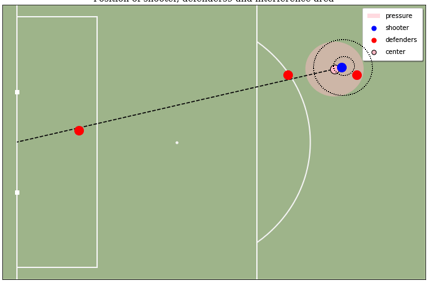

In [7]:
display.Image("img-notebook/interference-area.png")

In [20]:
def is_interfering(coord_shooter, coord_opponents):
    """
    Determine if an opponent is in the interference area

    Args:
        coord_shooter (tuple of floats): x, y of the shot-taker
        coord_opponents (tuple of floats): x, y of the opponent

    Returns:
        binary : yes or no 
    """
    x_s, y_s = coord_shooter[0], coord_shooter[1]
    x, y = coord_opponents[0], coord_opponents[1]
    signe = np.sign(x_s)
    
    # Solve the equation for the position of the center of the area
    constant = (y_s/(x_s - signe * 53)) # Simplify the following equation
    # The center is 0.5m from the shot-taker
    polynome = np.poly1d([constant**2+1, -2*x_s*(1+constant**2), x_s**2*(1+constant**2)-0.5**2]) 
    x_center = signe * np.max(np.abs((polynome.r)))
    y_center = (y_s/(x_s -signe * 53))* (x_center -x_s) + y_s

    # The area as a radius of 2m
    condition = (x-x_center)**2 + (y-y_center)**2 < 2**2
    if condition:
        return 1
    return 0


def calculate_number_intervene_opponents(row):
    """
    Determine how many opponents are near the shot taker
    Inspiration : Friends of Tracking - Laurie Shaw

    Args:
        row (row of a pandas DataFrame): positions of the opponents

    Returns:
        int : number of opponents in the area
    """
    goal_frame = row["Start Frame"]
    teamname = row["Team"]
    if teamname == "Home" : 
        team = tracking_away.loc[goal_frame]
    if teamname == "Away":
        team = tracking_home.loc[goal_frame]
    x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
    y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions

    coordinates = list(zip(team[x_columns], team[y_columns]))
    shooter_coord = row["Start X"], row["Start Y"]

    number = sum([is_interfering(shooter_coord, coor) for coor in coordinates])

    if number == 0 :
        return "Low"
    elif number == 1:
        return "Medium"
    elif number > 1:
        return "High"
    else:
        raise ValueError



In [21]:
shots["Interference_on_Shooter"] = shots.apply(calculate_number_intervene_opponents, axis=1)
shots.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,ShotAngle,DistanceToGoal,play_type,BodyPart,Goal,Number_Intervening_Opponents,Interference_on_Shooter
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,-39.22,18.36,-55.12,2.72,0.193935,22.956001,Open Play,Feet,0,3,Low
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04,0.975859,6.296825,Open Play,Feet,1,1,Medium
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,-41.34,11.56,-48.76,0.68,0.321587,16.419172,Open Play,Feet,0,2,Medium
297,Away,SHOT,BLOCKED,1,18515,740.60,18520,740.80,Player22,NaN,31.80,10.20,38.16,11.56,0.279795,23.526156,Open Play,Feet,0,1,Low
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,-43.46,-6.12,-54.06,-6.12,0.545456,11.334284,Open Play,Head,0,1,Medium


In [22]:
shots["Interference_on_Shooter"].value_counts()

Low       14
Medium     9
High       1
Name: Interference_on_Shooter, dtype: int64

## Visualisation of the data with the new features

In [23]:
# Retrieve the index of the shots
tirs_idx = list(shots.index)

# Choose a shot
shots_id=1723

# Finding goal frame
goal_frame = shots.loc[shots_id]['Start Frame']

Number of opponents blocking the view :  2
Interference on shooter :  Medium


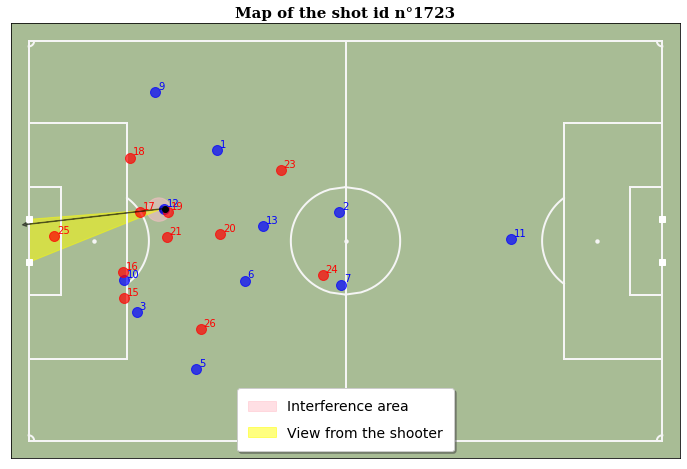

In [24]:
# Print some information to evaluate if they are representative of the situation
print("Number of opponents blocking the view : ", shots.loc[shots_id]["Number_Intervening_Opponents"])
print("Interference on shooter : ", shots.loc[shots_id]["Interference_on_Shooter"])

# See if the action is on the left or right side of the pitch
signe = np.sign(shots.loc[shots_id]["Start X"])

# Plot the shot direction
fig,ax = fot.plot_events(shots.loc[shots_id:shots_id], indicators = ['Marker','Arrow'], color="k")

# Plot the positions of the players
fig,ax = fot.plot_frame( tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], annotate=True, figax = (fig, ax) )

# Determine the interference area
x_s, y_s = shots.loc[shots_id]["Start X"], shots.loc[shots_id]["Start Y"]
signe = np.sign(x_s)
constant = (y_s/(x_s - signe * 53))
polynome = np.poly1d([constant**2+1, -2*x_s*(1+constant**2), x_s**2*(1+constant**2)-0.5**2])
x_center = signe * np.max(np.abs((polynome.r)))
y_center = (y_s/(x_s- signe * 53))* (x_center -x_s) + y_s

pressure = plt.Circle((x_center, y_center),2, color="pink", label="Interference area", alpha=0.5)
ax.add_patch(pressure)

# Draw the angle of shot
view = plt.Polygon(([signe * 53,7.32/2 ], [shots.loc[shots_id]["Start X"], shots.loc[shots_id]["Start Y"]], [signe * 53,-7.32/2 ]), 
                    fill=True, color="yellow", label="View from the shooter", alpha=0.5)
ax.add_patch(view)

plt.legend(loc='lower center',fontsize=14, markerscale=0.5,borderpad=0.8, labelspacing=0.9,shadow=True)
plt.title("Map of the shot id n°" + str(shots_id), fontsize = 15, color="black", fontfamily = "serif", fontweight="bold" )
plt.show()


## Use the model to evaluate the goal opportunities

In [25]:
# Load model from Step 1
with open("pickle_logreg_model.pkl", 'rb') as file:
    model = pickle.load(file)

In [26]:
# Preparation of the variables for the model

# Interference
dict_map = {"High" : 3, "Medium" : 2, "Low" : 1}
shots["Pressure"] = shots["Interference_on_Shooter"].map(dict_map)

# Body Part & Play Type
shots["BodyPartSaved"] = shots["BodyPart"] # I save the info
shots["play_type_saved"] =shots["play_type"] # I save the info
shots = pd.get_dummies(shots, columns=["BodyPart", "play_type"])
shots.rename(
    columns={
        "BodyPartSaved" : "BodyPart",
        "play_type_saved" : "play_type"
    }, inplace=True
)

# Add the column because the model needs it even if there is no occurence
shots["BodyPart_Other"] = 0

shots.head(5)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,ShotAngle,DistanceToGoal,Goal,Number_Intervening_Opponents,Interference_on_Shooter,Pressure,BodyPart,play_type,BodyPart_Feet,BodyPart_Head,play_type_Free Kick,play_type_Open Play,play_type_Penalty,BodyPart_Other
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,-39.22,18.36,-55.12,2.72,0.193935,22.956001,0,3,Low,1,Feet,Open Play,1,0,0,1,0,0
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04,0.975859,6.296825,1,1,Medium,2,Feet,Open Play,1,0,0,1,0,0
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,-41.34,11.56,-48.76,0.68,0.321587,16.419172,0,2,Medium,2,Feet,Open Play,1,0,0,1,0,0
297,Away,SHOT,BLOCKED,1,18515,740.60,18520,740.80,Player22,NaN,31.80,10.20,38.16,11.56,0.279795,23.526156,0,1,Low,1,Feet,Open Play,1,0,0,1,0,0
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,-43.46,-6.12,-54.06,-6.12,0.545456,11.334284,0,1,Medium,2,Head,Open Play,0,1,0,1,0,0


In [27]:
# Prepare the features for the model
features = ["DistanceToGoal","ShotAngle",
"Number_Intervening_Opponents","Pressure",
"BodyPart_Feet","BodyPart_Head","BodyPart_Other",
"play_type_Free Kick", "play_type_Open Play", 
"play_type_Penalty",
"Goal"]

X = shots[features].iloc[:,:-1]

# Prediction of the goal probability of the shots
shots["XG"] = model.predict_proba(X)[:,1]

shots.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,ShotAngle,DistanceToGoal,Goal,Number_Intervening_Opponents,Interference_on_Shooter,Pressure,BodyPart,play_type,BodyPart_Feet,BodyPart_Head,play_type_Free Kick,play_type_Open Play,play_type_Penalty,BodyPart_Other,XG
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,-39.22,18.36,-55.12,2.72,0.193935,22.956001,0,3,Low,1,Feet,Open Play,1,0,0,1,0,0,0.049296
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04,0.975859,6.296825,1,1,Medium,2,Feet,Open Play,1,0,0,1,0,0,0.389471
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,-41.34,11.56,-48.76,0.68,0.321587,16.419172,0,2,Medium,2,Feet,Open Play,1,0,0,1,0,0,0.086884
297,Away,SHOT,BLOCKED,1,18515,740.60,18520,740.80,Player22,NaN,31.80,10.20,38.16,11.56,0.279795,23.526156,0,1,Low,1,Feet,Open Play,1,0,0,1,0,0,0.087611
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,-43.46,-6.12,-54.06,-6.12,0.545456,11.334284,0,1,Medium,2,Head,Open Play,0,1,0,1,0,0,0.100691


In [28]:
# Shots
home_shots = shots[shots.Team=='Home']
away_shots = shots[shots.Team=='Away']

## Game through the lens of probabilies

We start by visualizing the shots and goals with their probability to be transformed in goals
Then I calculate the cumulative probabilities to score to check if the real score matches the expected one

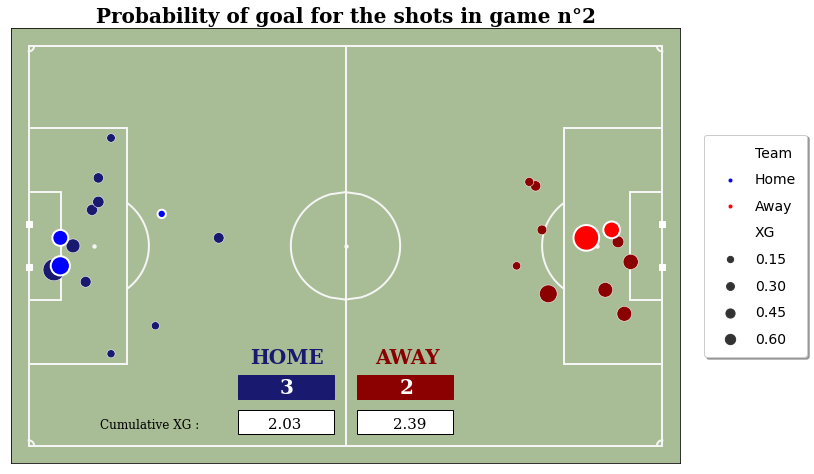

In [38]:
fig,ax = fot.plot_pitch(field_dimen=(106,68))

# Colors differently the goals and shots
colors= {"Away" : "darkred", "Home" : "MidnightBlue"}
colors_goal= {"Away" : "red", "Home" : "blue"}

# Plot the shots and goals
sns.scatterplot(data =shots[(shots["Goal"] == 0)], x='Start X', y='Start Y',
                hue="Team", palette=colors,
                size="XG", 
                size_norm=(0,1),
                linewidth=0.5,
                sizes=(30,900),
                legend=False,
                ax=ax,
                zorder=10)
sns.scatterplot(data =shots[(shots["Goal"] == 1)
                    ], x='Start X', y='Start Y',
                hue="Team", palette=colors_goal,
                size="XG", 
                size_norm=(0,1),
                sizes=(30,900),
                linewidth=2,
                legend='brief',
                ax=ax,
                zorder=10)

# The scoreboard 
home_score = plt.Polygon([[-18,-26], [-18,-22], [-2,-22],[-2,-26]], color="MidnightBlue")
away_score = plt.Polygon([[18,-26], [18,-22], [2,-22],[2,-26]], color="darkred")
home_xg = plt.Polygon([[-18,-32], [-18,-28], [-2,-28],[-2,-32]], facecolor='white', edgecolor="black")
away_xg = plt.Polygon([[18,-32], [18,-28], [2,-28],[2,-32]], facecolor='white', edgecolor="black")
ax.add_patch(home_score)
ax.add_patch(away_score)
ax.add_patch(home_xg)
ax.add_patch(away_xg)

ax.text(5,-20, "AWAY", color="darkred", fontsize=20, fontfamily="serif", fontweight="black")
ax.text(9,-25, str(int(away_shots["Goal"].sum())), color="white", fontsize=20, fontfamily="serif", fontweight="black")
ax.text(-16,-20, "HOME", color="MidnightBlue", fontsize=20, fontfamily="serif", fontweight="black")
ax.text(-11,-25, str(int(home_shots["Goal"].sum())), color="white", fontsize=20, fontfamily="serif", fontweight="black")

ax.text(-41,-31, "Cumulative XG : ", color="black", fontsize=12, fontfamily="serif")
ax.text(8,-31, str(round(away_shots["XG"].sum(),2)), color="black", fontsize=15, fontfamily="serif")
ax.text(-13,-31, str(round(home_shots["XG"].sum(),2)), color="black", fontsize=15, fontfamily="serif")

plt.title("Probability of goal for the shots in game n°2", fontsize=20, fontfamily='serif', color="black", fontweight="black")
plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5),fontsize=14, markerscale=0.5,borderpad=0.8, labelspacing=0.9,shadow=True)
plt.show()

We see that the cumulative probabilities seem to indicate that the Away Team should have been the winning team if we only look at the shooting opportunities

In [31]:
# Transform the time information in a more lisible one (mn)
shots["minutes"] = shots["Start Time [s]"]//60

home_shots = shots[shots.Team == "Home"]
away_shots = shots[shots.Team == "Away"]

In [32]:
# Count the cumulative probailities for each team through the game
home_shots["cumulative-xg"] = home_shots["XG"].cumsum()
away_shots["cumulative-xg"] = away_shots["XG"].cumsum()

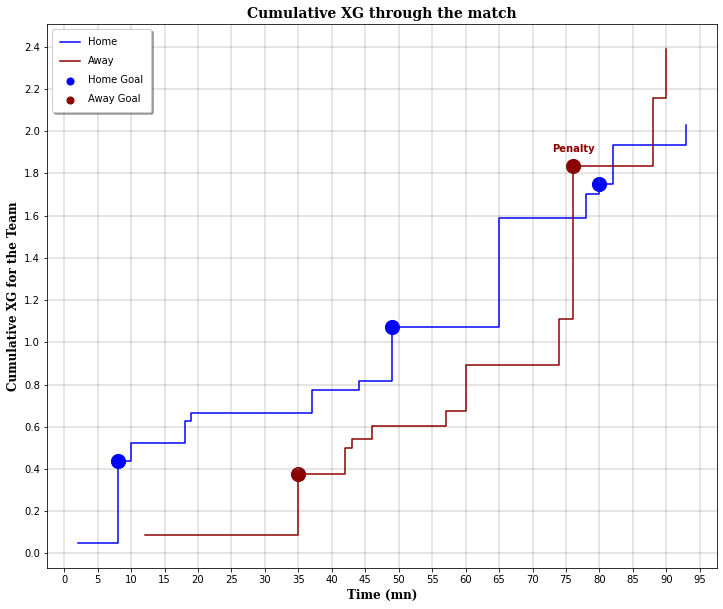

In [34]:
# Plot the probabilities evoluting during the game
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(1,1,1)

# Plot the evolution of the cumulative probabilities
ax.step(home_shots["minutes"], home_shots["cumulative-xg"], where="post",  label="Home", color="blue")
ax.step(away_shots["minutes"], away_shots["cumulative-xg"], where="post",  label="Away", color="darkred")

# Plot the goals
ax.scatter(home_shots[home_shots["Goal"] == 1]["minutes"], home_shots[home_shots["Goal"] == 1]["cumulative-xg"], color="blue", s=200, label="Home Goal")
ax.scatter(away_shots[away_shots["Goal"] == 1]["minutes"], away_shots[away_shots["Goal"] == 1]["cumulative-xg"], color="darkred", s=200, label="Away Goal")
ax.text(73,1.90, "Penalty", color="darkred",fontweight="bold")

plt.legend(loc='upper left',fontsize=10, markerscale=0.5,borderpad=0.8, labelspacing=0.9,shadow=True)
plt.title("Cumulative XG through the match", fontsize=14, fontweight="bold", fontfamily="serif")
plt.xlabel("Time (mn)", fontsize=12, fontweight="bold", fontfamily="serif")
ax.grid(color="grey", linestyle="-", linewidth=0.4)
plt.xticks([x for x in range(0,100,5)])
plt.yticks([x/10 for x in range(0,25,2)])
plt.ylabel("Cumulative XG for the Team", fontsize=12, fontweight="bold", fontfamily="serif")
plt.show()

We can see that the penalty had a major influence on the cumulative probability.

In [35]:
df_events.loc[1661:1671,:].tail(5)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1667,Home,RECOVERY,BLOCKED,2,111763,4470.52,111763,4470.52,Player7,NaN,47.70,-3.40,NaN,NaN
1668,Home,BALL LOST,HAND BALL,2,111763,4470.52,111763,4470.52,Player7,NaN,47.70,-3.40,NaN,NaN
1669,Home,CARD,YELLOW,2,113376,4535.04,113376,4535.04,Player7,NaN,NaN,NaN,NaN,NaN
1670,Away,SET PIECE,PENALTY,2,115009,4600.36,115009,4600.36,Player20,NaN,NaN,NaN,NaN,NaN
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,40.28,1.36,55.12,2.72


We see that the penalty has been provoked by a hand ball but does not seem to have prevented a shot

Seeing the action can give more information about that, but in regard of the shots opportunities it seems that the Home team deserved the win compared to the away team even if we could have been expected a score of 2 - 1 regarding to the cumulative probabilities